In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [3]:
# Define base directory
BASE_DIR = "/kaggle/input/wildlife-classification"

# Define paths
TRAIN_CSV_PATH = os.path.join(BASE_DIR, "train_features.csv")
TEST_CSV_PATH = os.path.join(BASE_DIR, "test_features.csv")
LABELS_CSV_PATH = os.path.join(BASE_DIR, "train_labels.csv")
TRAIN_IMG_DIR = os.path.join(BASE_DIR, "train_features")
TEST_IMG_DIR = os.path.join(BASE_DIR, "test_features")

In [4]:
train_features = pd.read_csv(TRAIN_CSV_PATH, index_col="id")
test_features = pd.read_csv(TEST_CSV_PATH, index_col="id")
train_labels = pd.read_csv(LABELS_CSV_PATH, index_col="id")

In [5]:
# Fix filepaths to absolute paths for Kaggle environment
train_features["filepath"] = train_features["filepath"].apply(
    lambda x: os.path.join(TRAIN_IMG_DIR, os.path.basename(x))
)

test_features["filepath"] = test_features["filepath"].apply(
    lambda x: os.path.join(TEST_IMG_DIR, os.path.basename(x))
)

In [6]:
train_features.head()

,filepath,site
id,,
ZJ000000,/kaggle/input/wildlife-classification/train_fe...,S0120
ZJ000001,/kaggle/input/wildlife-classification/train_fe...,S0069
ZJ000002,/kaggle/input/wildlife-classification/train_fe...,S0009
ZJ000003,/kaggle/input/wildlife-classification/train_fe...,S0008
ZJ000004,/kaggle/input/wildlife-classification/train_fe...,S0036


In [7]:
test_features.head()

,filepath,site
id,,
ZJ016488,/kaggle/input/wildlife-classification/test_fea...,S0082
ZJ016489,/kaggle/input/wildlife-classification/test_fea...,S0040
ZJ016490,/kaggle/input/wildlife-classification/test_fea...,S0040
ZJ016491,/kaggle/input/wildlife-classification/test_fea...,S0041
ZJ016492,/kaggle/input/wildlife-classification/test_fea...,S0040


In [8]:
train_labels.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
species_labels = sorted(train_labels.columns.unique())
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

random_state = 42

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

for species, ax in zip(species_labels, axes.flat):
    img_id = (
        train_labels[train_labels.loc[:, species] == 1]
        .sample(1, random_state=random_state)
        .index[0]
    )
    img_path = os.path.join(BASE_DIR, train_features.loc[img_id].filepath)
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(f"{img_id} | {species}")

In [ ]:
train_labels.sum().sort_values(ascending=False)

In [ ]:
from sklearn.model_selection import train_test_split

frac = 0.75

y = train_labels.sample(frac=frac, random_state=1)
x = train_features.loc[y.index].filepath.to_frame()

# note that we are casting the species labels to an indicator/dummy matrix
x_train, x_eval, y_train, y_eval = train_test_split(
    x, y, stratify=y, test_size=0.25
)

In [ ]:
x_train.head()

In [ ]:
y_train.head()

In [ ]:
x_train.shape, y_train.shape, x_eval.shape, y_eval.shape

((9274, 1), (9274, 8), (3092, 1), (3092, 8))

In [ ]:
class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_df, y_df=None):
        self.data = x_df
        self.label = y_df
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __getitem__(self, index):
        image = Image.open(self.data.iloc[index]["filepath"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.index[index]
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image_id": image_id, "image": image}
        else:
            label = torch.tensor(self.label.iloc[index].values, 
                                 dtype=torch.float)
            sample = {"image_id": image_id, "image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

In [17]:
from torch.utils.data import DataLoader

train_dataset = ImagesDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32)

In [18]:
from torch import nn
import torchvision.models as models

model = models.efficientnet_b0(pretrained=True)
model.classifier = nn.Sequential(
    nn.Linear(1280, 100),  # dense layer takes a 1280-dim input and outputs 100-dim
    nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
    nn.Dropout(0.1),  # common technique to mitigate overfitting
    nn.Linear(
        100, 8
    ),  # final dense layer outputs 8-dim corresponding to our target classes
)

# Move to device
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 149MB/s]


In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

In [20]:
num_epochs = 3

tracking_loss = {}

for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch}")

    # iterate through the dataloader batches. tqdm keeps track of progress.
    for batch_n, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()
        
        inputs = batch["image"].to(device)
        labels = batch["label"].to(device)
    
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        tracking_loss[(epoch, batch_n)] = float(loss)
    
        loss.backward()
        optimizer.step()

Starting epoch 1


100%|██████████| 290/290 [02:06<00:00,  2.29it/s]


Starting epoch 2


100%|██████████| 290/290 [01:07<00:00,  4.33it/s]


Starting epoch 3


100%|██████████| 290/290 [01:06<00:00,  4.33it/s]


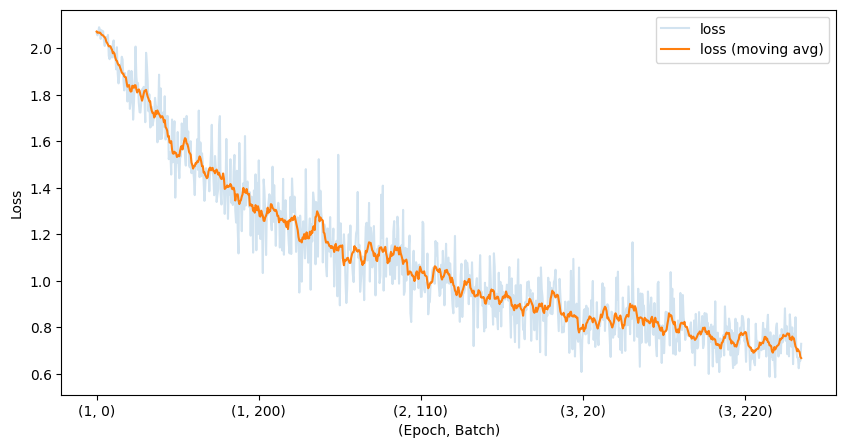

In [21]:
tracking_loss = pd.Series(tracking_loss)

plt.figure(figsize=(10, 5))
tracking_loss.plot(alpha=0.2, label="loss")
tracking_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
    label="loss (moving avg)"
)
plt.xlabel("(Epoch, Batch)")
plt.ylabel("Loss")
plt.legend(loc=0)

In [22]:
torch.save(model, "model.pth")

In [23]:
loaded_model = torch.load("model.pth")

/tmp/ipykernel_31/453570178.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load("model.pth")


In [24]:
eval_dataset = ImagesDataset(x_eval, y_eval)
eval_dataloader = DataLoader(eval_dataset, batch_size=32)

In [25]:
preds_collector = []

model.eval()

with torch.no_grad():
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
        # 1) move batch to device
        inputs = batch["image"].to(device)

        # 2) run the forward step
        logits = model(inputs)

        # 3) apply softmax
        preds = nn.functional.softmax(logits, dim=1)

        # 4) move predictions to CPU and convert to numpy
        preds_df = pd.DataFrame(
            preds.detach().cpu().numpy(),  # <-- move to CPU before converting
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

eval_preds_df = pd.concat(preds_collector)

100%|██████████| 97/97 [00:40<00:00,  2.38it/s]


In [26]:
print("True labels (training):")
y_train.idxmax(axis=1).value_counts()

True labels (training):


monkey_prosimian    1422
antelope_duiker     1392
civet_genet         1383
blank               1264
leopard             1258
rodent              1122
bird                 905
hog                  528
Name: count, dtype: int64

In [27]:
print("Predicted labels (eval):")
eval_preds_df.idxmax(axis=1).value_counts()

Predicted labels (eval):


civet_genet         485
monkey_prosimian    468
blank               458
antelope_duiker     427
leopard             414
rodent              347
bird                308
hog                 185
Name: count, dtype: int64

In [28]:
print("True labels (eval):")
y_eval.idxmax(axis=1).value_counts()

True labels (eval):


monkey_prosimian    474
antelope_duiker     465
civet_genet         461
blank               421
leopard             419
rodent              374
bird                302
hog                 176
Name: count, dtype: int64

In [29]:
eval_predictions = eval_preds_df.idxmax(axis=1)
eval_predictions.head()

ZJ008900             rodent
ZJ009907               bird
ZJ011771        civet_genet
ZJ012893    antelope_duiker
ZJ011209    antelope_duiker
dtype: object

In [30]:
eval_true = y_eval.idxmax(axis=1)
correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)
accuracy

0.8392626131953428

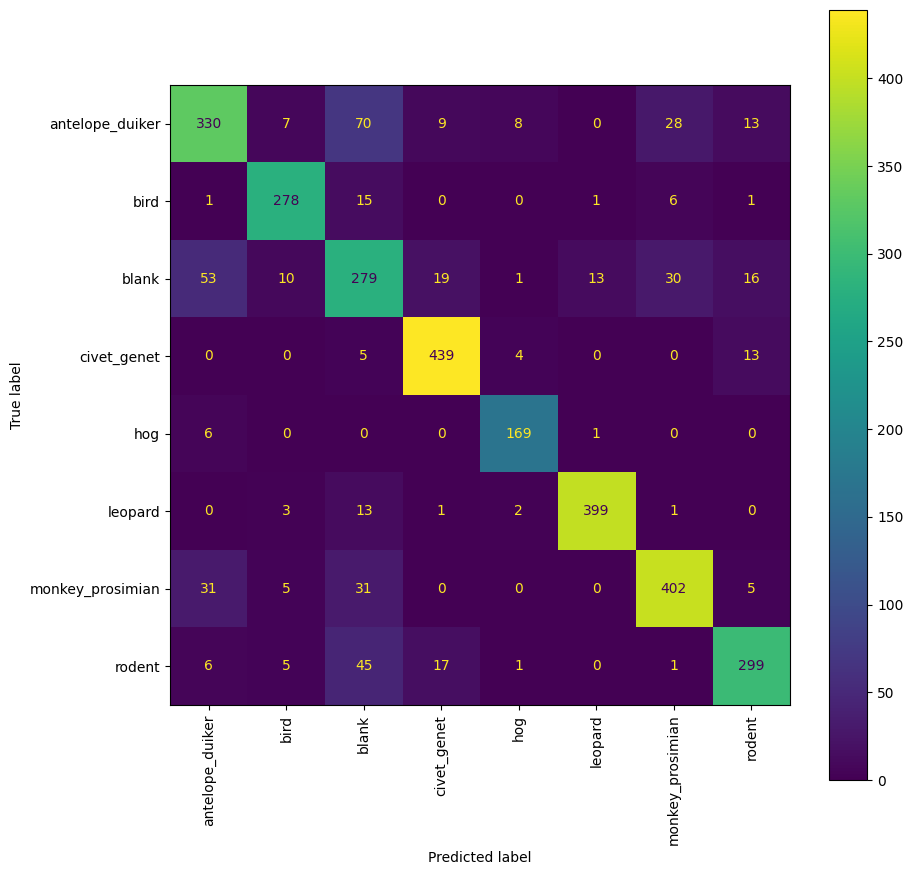

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_eval.idxmax(axis=1),
    eval_preds_df.idxmax(axis=1),
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)

In [32]:
test_dataset = ImagesDataset(test_features.filepath.to_frame())
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [33]:
preds_collector = []

model.eval()

with torch.no_grad():
    for batch in tqdm(test_dataloader, total=len(test_dataloader)):
        # move image tensor to device
        inputs = batch["image"].to(device)

        # forward pass
        logits = model(inputs)

        # softmax
        preds = nn.functional.softmax(logits, dim=1)

        # move predictions to CPU and convert to numpy
        preds_df = pd.DataFrame(
            preds.detach().cpu().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

final_preds = pd.concat(preds_collector)

100%|██████████| 140/140 [00:57<00:00,  2.43it/s]


In [34]:
final_preds

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ016488,0.046840,0.073290,0.173364,0.143363,0.032630,0.490481,0.019355,0.020677
ZJ016489,0.580815,0.082500,0.098092,0.027542,0.109426,0.016922,0.059738,0.024964
ZJ016490,0.623275,0.021032,0.077010,0.063079,0.148384,0.018477,0.010886,0.037858
ZJ016491,0.024383,0.025114,0.034048,0.034948,0.050191,0.770771,0.023637,0.036907
ZJ016492,0.034757,0.019515,0.024768,0.032165,0.018462,0.007700,0.828840,0.033792
...,...,...,...,...,...,...,...,...
ZJ020947,0.166081,0.008599,0.560305,0.008426,0.024862,0.045413,0.179874,0.006440
ZJ020948,0.272504,0.058676,0.431539,0.013055,0.049552,0.098192,0.045623,0.030858
ZJ020949,0.160867,0.011629,0.082500,0.084274,0.590555,0.053335,0.004975,0.011866
ZJ020950,0.840226,0.023024,0.014664,0.011946,0.052786,0.029360,0.018503,0.009491
